In [1]:
from morphSimilarity import *
from neighborJoining import *

import numpy as np
from pathlib import Path
from skimage import io
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from skimage import measure
from skimage.future import graph
import networkx as nx
from scipy import ndimage
import sys
import pickle
from tqdm.notebook import tqdm
from pymks import PrimitiveTransformer, TwoPointCorrelation
from sklearn.pipeline import Pipeline
from scipy.spatial import distance as dist


%reload_ext autoreload
%autoreload 2
%matplotlib inline

compute distance function parameters

In [151]:
image_set_directory=['/home/namit/data/extreme_aspect_ratio_reduced/10x80/',
                     '/home/namit/data/extreme_aspect_ratio_reduced/80x10/',
                     '/home/namit/data/extreme_aspect_ratio_reduced/10x10/',
                     '/home/namit/data/extreme_aspect_ratio_reduced/80x80/']

# image_set_directory = '/home/namit/data/thin_films_numbered'



# signature_function='surface_volume_ratio_sig'
signature_function='shape_ratio_sig'
# signature_function='fractal_dimension_sig'

visualize_graphs=False
weighted=False
cosine=True

compute the distance matrix

In [7]:
distances = compute_distance(image_set_directory, signature_function, visualize_graphs, weighted, cosine)

/home/namit/data/thin_films_numbered/a.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/b.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/c.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/d.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/e.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/f.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/g.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/h.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/i.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/j.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/k.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/l.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/m.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/n.png
Pruned 0 component(s)
/home/namit/data/thin_films_numbered/o.png
Pruned 0 component(s)
/home/namit/data/thin_fil

plot the distance matrix

In [2]:
def get_normalized_matrix(distance_matrix):
    return (distance_matrix - np.min(distance_matrix))/(np.max(distance_matrix)-np.min(distance_matrix))

In [14]:
distances_cosine = np.load('distances_80_negative_cosine.npy')
distances_cosine_norm = get_normalized_matrix(distances_cosine)
distances_euclidean = np.load('distances_80_euclidean_dsquared.npy')
distances_euclidean_norm = get_normalized_matrix(distances_euclidean)

Text(0.5, 1.0, 'Euclidean Distance - Extreme Aspect Ratio')

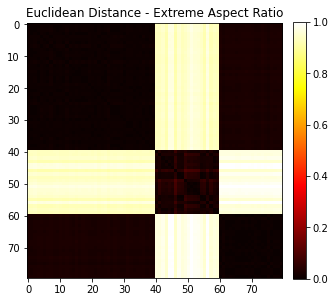

In [15]:
fig = plt.figure(figsize=(5,5))

plt.imshow(distances_euclidean_norm, cmap='hot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Euclidean Distance - Extreme Aspect Ratio')

Text(0.5, 1.0, 'Cosine Distance - Extreme Aspect Ratio')

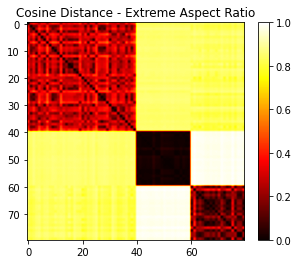

In [16]:
# fig = plt.figure(figsize=(10,10))

# ax = fig.add_subplot(121)
# ax.imshow(distances_cosine, cmap='hot')
# cbar = ax.colorbar(fraction=0.046, pad=0.04)

plt.imshow(distances_cosine_norm, cmap='hot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
# cbar = ax.colorbar(fraction=0.046, pad=0.04)
plt.title('Cosine Distance - Extreme Aspect Ratio')

In [17]:
from sklearn.manifold import MDS
mds = MDS(2, dissimilarity='euclidean')
data_euclidean = mds.fit_transform(distances_euclidean_norm)
data_cosine = mds.fit_transform(distances_cosine_norm)

/home/namit/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/home/namit/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


Text(30, 40, 'Morphology B')

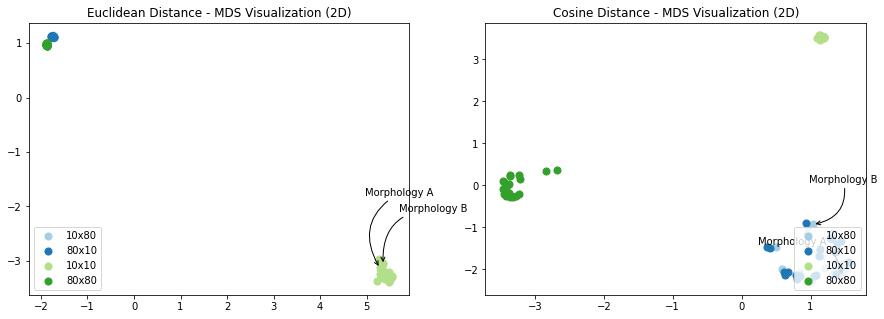

In [18]:
a = (166/255,206/255,227/255)
b = (31/255,120/255,180/255)
c = (178/255,223/255,138/255)
d = (51/255,160/255,44/255)

colors = [a,b,c,d]

size = 50
morphs_per_trajectory = 20
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
data = data_euclidean
ax.scatter([point[0] for point in data[:20]], [point[1] for point in data[:20]], 
           s=size,
           color=colors[0], 
           label=r'10x80')
ax.scatter([point[0] for point in data[20:40]], [point[1] for point in data[20:40]], 
           s=size,
           color=colors[1], 
           label=r'80x10')
ax.scatter([point[0] for point in data[40:60]], [point[1] for point in data[40:60]], 
           s=size,
           color=colors[2], 
           label=r'10x10')
ax.scatter([point[0] for point in data[60:80]], [point[1] for point in data[60:80]], 
           s=size,
           color=colors[3], 
           label=r'80x80')
ax.legend()
ax.legend(loc='lower left')
ax.set_title("Euclidean Distance - MDS Visualization (2D)")

# annotate outlier trajectories
ax.annotate('Morphology A', xy=(data[43][0], data[43][1]), xytext=(20,70), 
            textcoords='offset points', ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
            color='black'))
ax.annotate('Morphology B', xy=(data[57][0], data[57][1]), xytext=(50,50), 
            textcoords='offset points', ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
            color='black'))



ax = fig.add_subplot(122)
data = data_cosine
ax.scatter([point[0] for point in data[:20]], [point[1] for point in data[:20]], 
           s=size,
           color=colors[0], 
           label=r'10x80')
ax.scatter([point[0] for point in data[20:40]], [point[1] for point in data[20:40]], 
           s=size,
           color=colors[1], 
           label=r'80x10')
ax.scatter([point[0] for point in data[40:60]], [point[1] for point in data[40:60]], 
           s=size,
           color=colors[2], 
           label=r'10x10')
ax.scatter([point[0] for point in data[60:80]], [point[1] for point in data[60:80]], 
           s=size,
           color=colors[3], 
           label=r'80x80')
ax.legend(loc='lower right')
ax.set_title("Cosine Distance - MDS Visualization (2D)")

# annotate outlier trajectories
ax.annotate('Morphology A', xy=(data[3][0], data[3][1]), xytext=(-50,30), 
            textcoords='offset points', ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
            color='black'))
ax.annotate('Morphology B', xy=(data[7][0], data[7][1]), xytext=(30,40), 
            textcoords='offset points', ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
            color='black'))


Text(30, 30, '7')

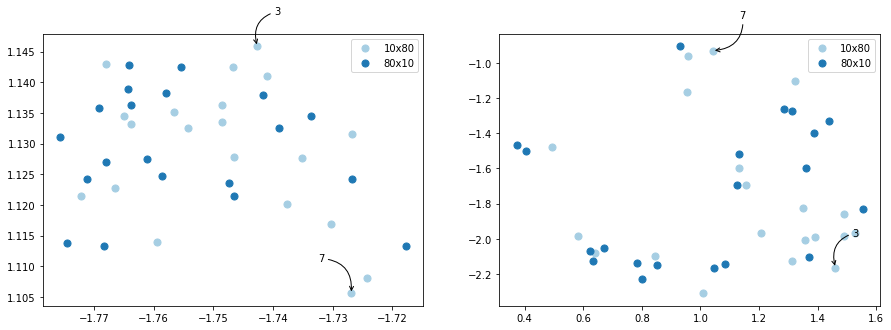

In [19]:
a = (166/255,206/255,227/255)
b = (31/255,120/255,180/255)
c = (178/255,223/255,138/255)
d = (51/255,160/255,44/255)

colors = [a,b,c,d]

size = 50
morphs_per_trajectory = 20
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
data = data_euclidean
ax.scatter([point[0] for point in data[:20]], [point[1] for point in data[:20]], 
           s=size,
           color=colors[0], 
           label=r'10x80')
ax.scatter([point[0] for point in data[20:40]], [point[1] for point in data[20:40]], 
           s=size,
           color=colors[1], 
           label=r'80x10')
# ax.scatter([point[0] for point in data[40:60]], [point[1] for point in data[40:60]], 
#            s=size,
#            color=colors[2], 
#            label=r'10x10')
# ax.scatter([point[0] for point in data[60:80]], [point[1] for point in data[60:80]], 
#            s=size,
#            color=colors[3], 
#            label=r'80x80')
ax.legend()

# annotate outlier trajectories
ax.annotate(3, xy=(data[3][0], data[3][1]), xytext=(20,30), 
            textcoords='offset points', ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
            color='black'))
ax.annotate(7, xy=(data[7][0], data[7][1]), xytext=(-30,30), 
            textcoords='offset points', ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
            color='black'))



ax = fig.add_subplot(122)
data = data_cosine
ax.scatter([point[0] for point in data[:20]], [point[1] for point in data[:20]], 
           s=size,
           color=colors[0], 
           label=r'10x80')
ax.scatter([point[0] for point in data[20:40]], [point[1] for point in data[20:40]], 
           s=size,
           color=colors[1], 
           label=r'80x10')
# ax.scatter([point[0] for point in data[40:60]], [point[1] for point in data[40:60]], 
#            s=size,
#            color=colors[2], 
#            label=r'10x10')
# ax.scatter([point[0] for point in data[60:80]], [point[1] for point in data[60:80]], 
#            s=size,
#            color=colors[3], 
#            label=r'80x80')
ax.legend()

# annotate outlier trajectories
ax.annotate(3, xy=(data[3][0], data[3][1]), xytext=(20,30), 
            textcoords='offset points', ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', 
            color='black'))
ax.annotate(7, xy=(data[7][0], data[7][1]), xytext=(30,30), 
            textcoords='offset points', ha='center', va='bottom',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5', 
            color='black'))


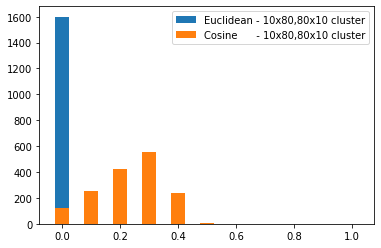

In [20]:
bins = np.arange(0,1.1,0.1)


inds_euclidean = np.digitize(distances_euclidean_norm[:40, :40].flatten(), bins)
freq_euclidean = {}
for i in range(1, len(bins)+1):
    freq_euclidean[bins[i-1]] = np.count_nonzero(inds_euclidean == i)

inds_cosine = np.digitize(distances_cosine_norm[:40, :40].flatten(), bins)
freq_cosine = {}
for i in range(1, len(bins)+1):
    freq_cosine[bins[i-1]] = np.count_nonzero(inds_cosine == i)
    
plt.bar(freq_euclidean.keys(), freq_euclidean.values(), 0.05, label="Euclidean - 10x80,80x10 cluster")
plt.bar(freq_cosine.keys(), freq_cosine.values(), 0.05, label="Cosine      - 10x80,80x10 cluster")
plt.legend()

In [21]:
# cosine not working - 3,7 - 4,8 - 10x80
distances_euclidean[3,7], distances_cosine[3,7], np.min(distances_cosine), np.max(distances_euclidean)

(8.94057456747325, -0.6148326142918314, -1.0, 763.0269338583804)

In [72]:
# cosine working - 3,6 - 4,7
distances_euclidean_norm[3,6], distances_cosine_norm[3,6]

(0.0389560175932149, 0.02582008300694632)

---

### cosine not works

In [22]:
image_set_directory = '/home/namit/data/selected_extreme_aspect/cosine_no_work'



# signature_function='surface_volume_ratio_sig'
signature_function='shape_ratio_sig'
# signature_function='fractal_dimension_sig'


visualize_graphs=True
weighted=False
cosine=True

v1, v2 = compute_distance(image_set_directory, signature_function, visualize_graphs, weighted, cosine)

/home/namit/data/selected_extreme_aspect/cosine_no_work/4.png
Pruned 0 component(s)
generated graph file:  graphs/4.png
/home/namit/data/selected_extreme_aspect/cosine_no_work/8.png
Pruned 0 component(s)
generated graph file:  graphs/8.png


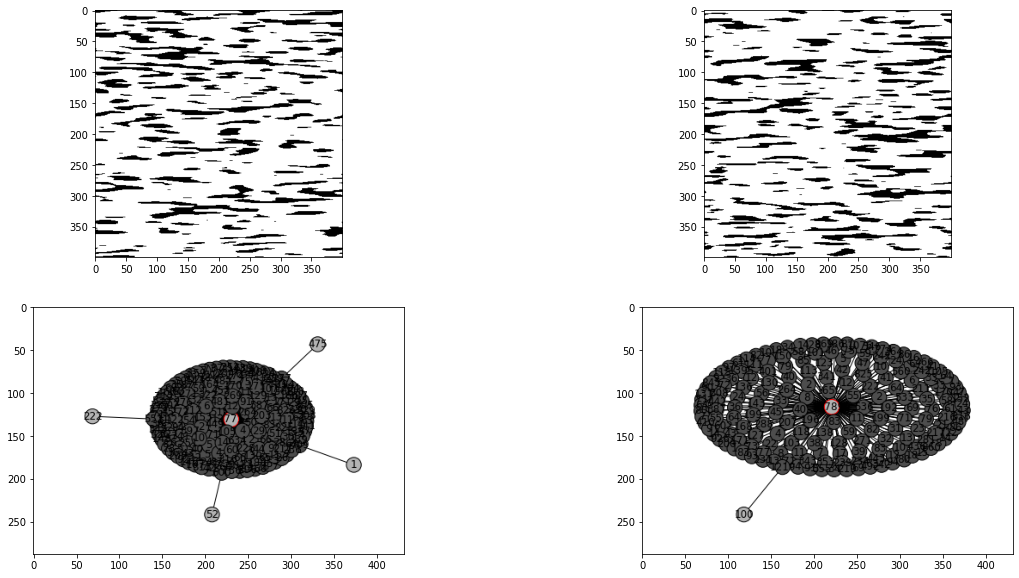

In [23]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(221)
plt.imshow(plt.imread('/home/namit/data/selected_extreme_aspect/cosine_no_work/4.png'))
fig.add_subplot(222)
plt.imshow(plt.imread('/home/namit/data/selected_extreme_aspect/cosine_no_work/8.png'))
fig.add_subplot(223)
plt.imshow(plt.imread('/home/namit/codes/CoMoDO/graphs/4.png'))
fig.add_subplot(224)
plt.imshow(plt.imread('/home/namit/codes/CoMoDO/graphs/8.png'))

In [76]:
fractional_cosine_similarity_denominator

-0.02507970935934445

In [31]:
d = np.linalg.norm(v1 - v2)
# compute d squared for coparison
total_euclidean_distance_squared = np.power(d, 2)

total_cosine_distance = dist.cosine(v1,v2) - 1
fractional_cosine_similarity_denominator = np.sum(v1*v2)


euclidean_distance = []
cosine_distance = []
euclidean_cummulative = 0
cosine_cummulative = 0


# for i in range(1, len(v1)+1):
#     part_v1, part_v2 = v1[:i], v2[:i]
#     cosine_distance.append(  dist.cosine(part_v1, part_v2) / np.max(distances_cosine)  )
#     euclidean_distance.append(  np.linalg.norm(part_v1 - part_v2) / np.max(distances_euclidean) )


for i in range(len(v1)):
    fractional_euclidean_distance = np.power((v2[i]-v1[i]),2)/total_euclidean_distance_squared
    fractional_cosine_similarity = v1[i]*v2[i]/fractional_cosine_similarity_denominator
    
    
#     euclidean_distance.append(  fractional_euclidean_distance  )
#     cosine_distance.append(  fractional_cosine_similarity )
    
    euclidean_cummulative += fractional_euclidean_distance
    cosine_cummulative += fractional_cosine_similarity
    
    euclidean_distance.append(euclidean_cummulative)
    cosine_distance.append(cosine_cummulative)

    
print(total_euclidean_distance_squared, total_cosine_distance)

39.164620129754105 0.0013124004791014166


In [30]:
cosine_distance

array([], dtype=float64)

In [44]:
1 + (np.sum(cosine_distance))

0.16417581707122397

In [232]:
print(euclidean_distance[-1], cosine_distance[-1])

0.06577836753407186 0.1728734583353745


In [63]:
v1-v2

array([ 0.00000000e+00, -1.66666667e-02, -8.68055556e-03, -6.94444444e-03,
       -1.00628931e-02, -8.69565217e-03, -7.19054956e-03, -5.68181818e-04,
        0.00000000e+00, -2.47096615e-04,  0.00000000e+00,  0.00000000e+00,
        1.74216028e-03,  2.64550265e-03, -2.84900285e-03, -2.84900285e-03,
       -5.26870390e-03, -1.05485232e-03,  0.00000000e+00,  3.62318841e-03,
        4.90196078e-03,  2.86944046e-03,  3.95256917e-03,  3.35148722e-03,
        2.67379679e-03,  0.00000000e+00,  2.84090909e-03,  2.84090909e-03,
        3.29380764e-03,  3.29781837e-03,  3.02419355e-03,  6.25000000e-03,
        4.76190476e-03,  5.88550027e-03,  6.41025641e-03,  6.67408231e-03,
        5.23399015e-03,  6.03494866e-03,  6.90250216e-03,  5.26315789e-03,
        7.91366906e-03,  8.10810811e-03,  8.10810811e-03,  5.24737631e-03,
        4.73684211e-03,  5.84795322e-03,  5.84795322e-03,  5.05050505e-03,
        4.31499461e-03,  5.53319920e-03,  5.53319920e-03,  7.79967159e-03,
        9.13621262e-03,  

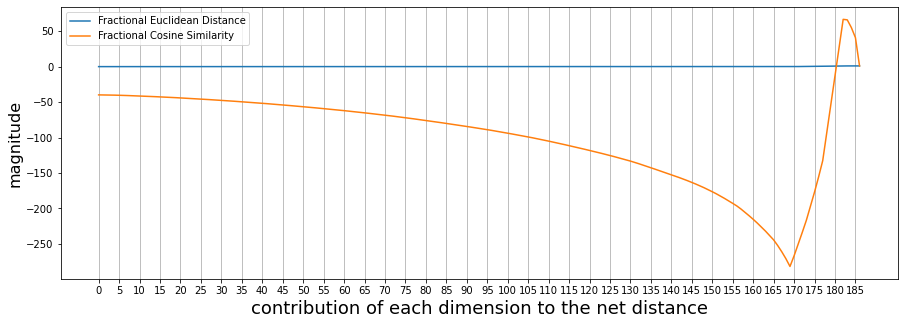

In [32]:
fig = plt.figure(figsize=(15,5))
plt.plot(euclidean_distance, label="Fractional Euclidean Distance")
plt.plot(cosine_distance, label='Fractional Cosine Similarity')
a = plt.xticks(np.arange(0, len(cosine_distance)+1, 5.0))
plt.grid(axis = 'x')
plt.xlabel('contribution of each dimension to the net distance', fontsize=18)
plt.ylabel('magnitude', fontsize=16)
plt.legend()

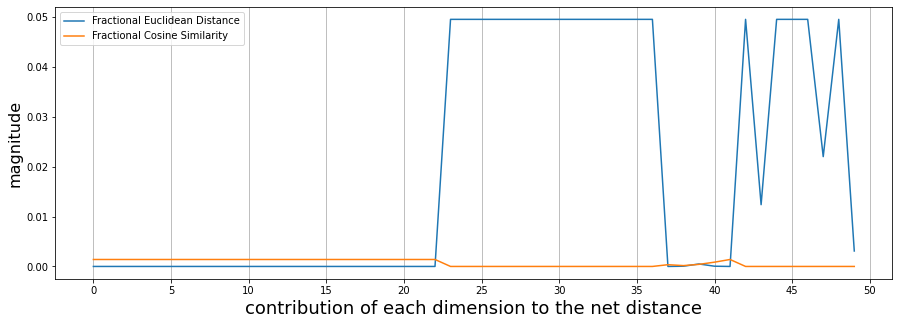

In [124]:
fig = plt.figure(figsize=(15,5))
plt.plot(euclidean_distance[-50:], label="Fractional Euclidean Distance")
plt.plot(cosine_distance[-50:], label='Fractional Cosine Similarity')
a = plt.xticks(np.arange(0, len(cosine_distance[-50:])+1, 5.0))
plt.grid(axis = 'x')
plt.xlabel('contribution of each dimension to the net distance', fontsize=18)
plt.ylabel('magnitude', fontsize=16)
plt.legend()

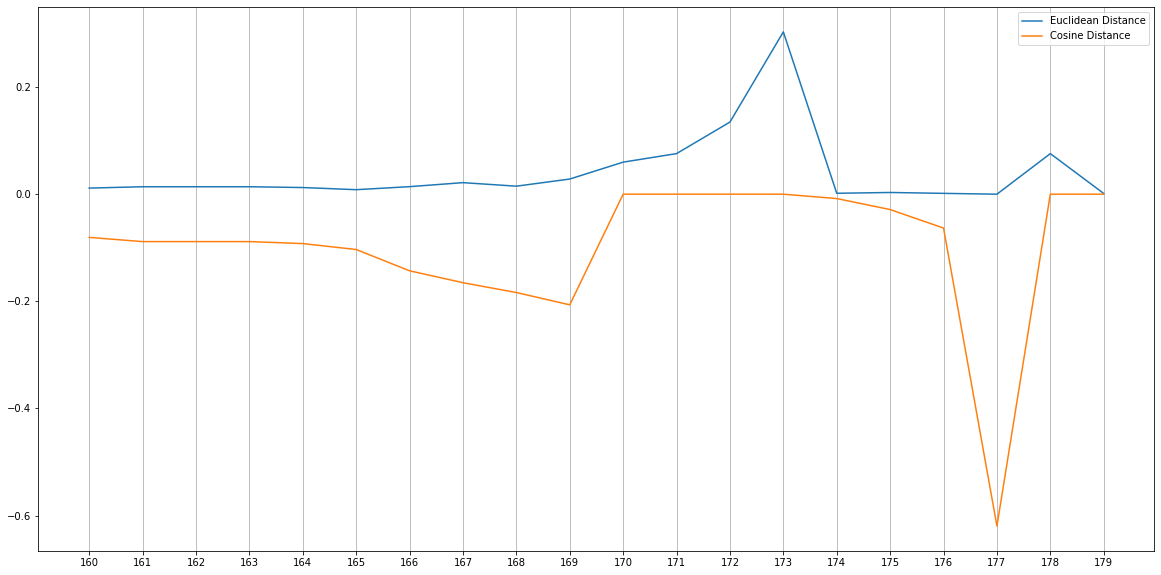

In [60]:
# zoom in
fig = plt.figure(figsize=(20,10))
plt.plot(np.arange(160, 180, 1.0), euclidean_distance[160:180], label="Euclidean Distance")
plt.plot(np.arange(160, 180, 1.0), cosine_distance[160:180], label='Cosine Distance')
a = plt.xticks(np.arange(160, 180, 1.0))
plt.grid(axis = 'x')
plt.legend()

#### components 169-173

<ipython-input-125-ffb6dd2e8976>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',f'10x80 morph #7', f'10x80 morph #3'])


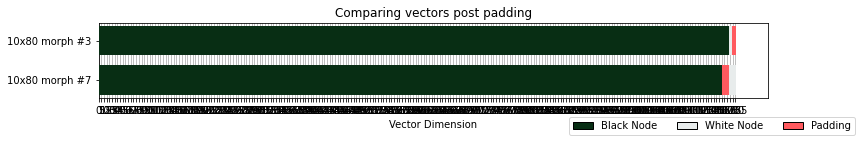

In [125]:
padded_vectors = [v1,v2]
fig, ax = plt.subplots(figsize=(12,2))
ticks = np.arange(0, len(padded_vectors[0]), 20)
minor_ticks = np.arange(0, len(padded_vectors[0]), 5)
ax.set_xticks(ticks)
ax.set_xticks(ticks, minor=True)
ax.set_yticklabels(['',f'10x80 morph #7', f'10x80 morph #3'])
plt.grid(True, axis='x', linestyle='-',zorder=0)

plt.setp(ax.get_xminorticklabels(), visible=False)

plt.xlabel("Vector Dimension")
plt.title("Comparing vectors post padding")

legend = [Patch(facecolor=[8/255,46/255,20/255],     edgecolor='k',label='Black Node'),
          Patch(facecolor=[232/255,236/255,236/255], edgecolor='k',label='White Node'),
          Patch(facecolor=[255/255,90/255,95/255],   edgecolor='k',label='Padding')]
plt.legend(handles=legend, bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=3)

plt.tight_layout()



for i in range(len(padded_vectors[0])):
    if padded_vectors[0][i]==0:
        c1 = [255/255,90/255,95/255]
    elif padded_vectors[0][i]>0:
        c1 = [232/255,236/255,236/255]
    else:
        c1 = [8/255,46/255,20/255]
        
    if padded_vectors[1][i]==0:
        c2 = [255/255,90/255,95/255]
    elif padded_vectors[1][i]>0:
        c2 = [232/255,236/255,236/255]
    else:
        c2 = [8/255,46/255,20/255]
        
    color=[c1,c2]
    plt.barh([0,1], [1,1], left=i, color=color, height=0.75, orientation='horizontal',zorder=3)
    a = plt.xticks(np.arange(0, len(v1)+1, 5.0))
plt.show()

<ipython-input-34-3b1589497c94>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',f'10x80 morph #3', f'10x80 morph #5'])


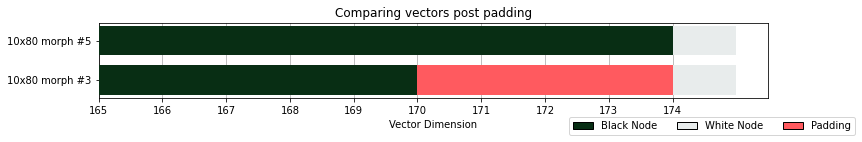

In [34]:
padded_vectors = [v1[165:175],v2[165:175]]
fig, ax = plt.subplots(figsize=(12,2))
ticks = np.arange(0, len(padded_vectors[0]), 20)
minor_ticks = np.arange(0, len(padded_vectors[0]), 5)
ax.set_xticks(ticks)
ax.set_xticks(ticks, minor=True)
ax.set_yticklabels(['',f'10x80 morph #3', f'10x80 morph #5'])
plt.grid(True, axis='x', linestyle='-',zorder=0)

plt.setp(ax.get_xminorticklabels(), visible=False)

plt.xlabel("Vector Dimension")
plt.title("Comparing vectors post padding")

legend = [Patch(facecolor=[8/255,46/255,20/255],     edgecolor='k',label='Black Node'),
          Patch(facecolor=[232/255,236/255,236/255], edgecolor='k',label='White Node'),
          Patch(facecolor=[255/255,90/255,95/255],   edgecolor='k',label='Padding')]
plt.legend(handles=legend, bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=3)

plt.tight_layout()



for i in range(len(padded_vectors[0])):
    if padded_vectors[0][i]==0:
        c1 = [255/255,90/255,95/255]
    elif padded_vectors[0][i]>0:
        c1 = [232/255,236/255,236/255]
    else:
        c1 = [8/255,46/255,20/255]
        
    if padded_vectors[1][i]==0:
        c2 = [255/255,90/255,95/255]
    elif padded_vectors[1][i]>0:
        c2 = [232/255,236/255,236/255]
    else:
        c2 = [8/255,46/255,20/255]
        
    color=[c1,c2]
    plt.barh([0,1], [1,1], left=i, color=color, height=0.75, orientation='horizontal',zorder=3)
    a = plt.xticks(np.arange(10))
    ax.set_xticklabels(np.arange(165, 175))
plt.show()

In [56]:
import pandas as pd

pd.DataFrame(euclidean_distance, columns = ['each dimension contribution']).tail(25)


,each dimension contribution
157,0.009659
158,0.013554
159,0.014219
160,0.011399
161,0.013909
162,0.013909
163,0.013909
164,0.012406
165,0.008414
166,0.014052


In [65]:
image_set_directory = '/home/namit/data/selected_extreme_aspect/cosine_no_work'



# signature_function='surface_volume_ratio_sig'
signature_function='shape_ratio_sig'
# signature_function='fractal_dimension_sig'


visualize_graphs=False
weighted=False
cosine=True

components = compute_distance(image_set_directory, signature_function, visualize_graphs, weighted, cosine)

/home/namit/data/selected_extreme_aspect/cosine_no_work/4.png
Pruned 0 component(s)
/home/namit/data/selected_extreme_aspect/cosine_no_work/6.png
Pruned 0 component(s)


In [66]:
# plot each component individualy
image_num = 0
fig = plt.figure(figsize=(10,70))
for i in range(len(components[image_num][174:176])):
    ax = fig.add_subplot(10, 2, (i*2+1))
    ax.imshow(components[image_num][174:176][i], cmap='gray')
for i in range(1,len(components[image_num][174:176])):
    ax = fig.add_subplot(10, 2, i*2)
    ax.imshow(components[image_num][174:176][i], cmap='gray')

<Figure size 720x5040 with 0 Axes>

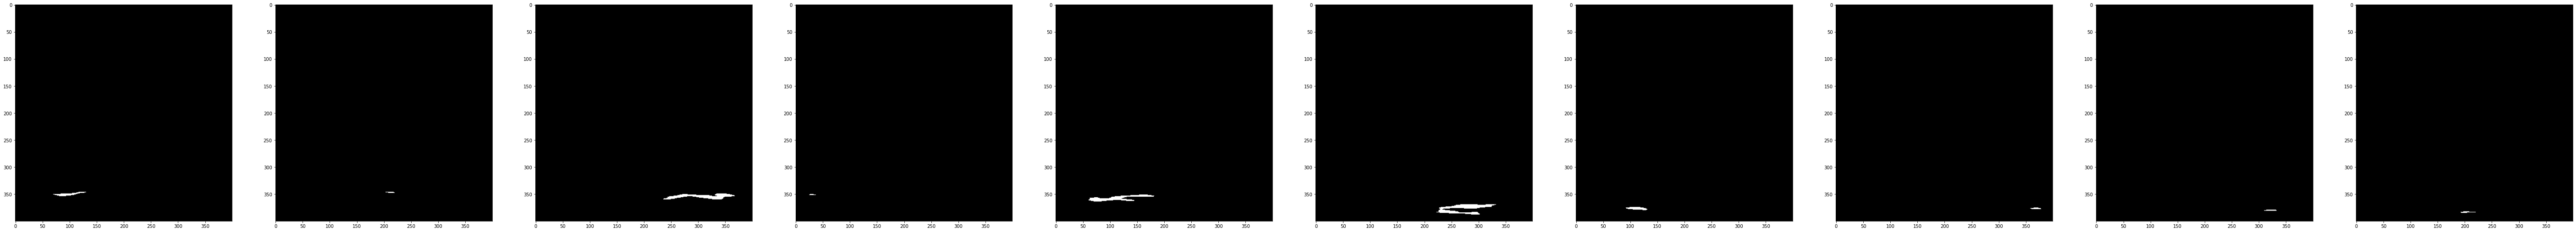

In [309]:
# plot each component individualy
image_num = 1
fig = plt.figure(figsize=(100,10))
for i in range(len(components[image_num][165:175])):
    ax = fig.add_subplot(1, int(len(components[image_num][165:175])), i+1)
    ax.imshow(components[image_num][165:175][i], cmap='gray')

---

### cosine works

In [380]:
image_set_directory = '/home/namit/data/selected_extreme_aspect/cosine_works'



# signature_function='surface_volume_ratio_sig'
signature_function='shape_ratio_sig'
# signature_function='fractal_dimension_sig'


visualize_graphs=True
weighted=False
cosine=True

v1, v2 = compute_distance(image_set_directory, signature_function, visualize_graphs, weighted, cosine)

/home/namit/data/selected_extreme_aspect/cosine_works/4.png
Pruned 0 component(s)
generated graph file:  graphs/4.png
/home/namit/data/selected_extreme_aspect/cosine_works/7.png
Pruned 0 component(s)
generated graph file:  graphs/7.png


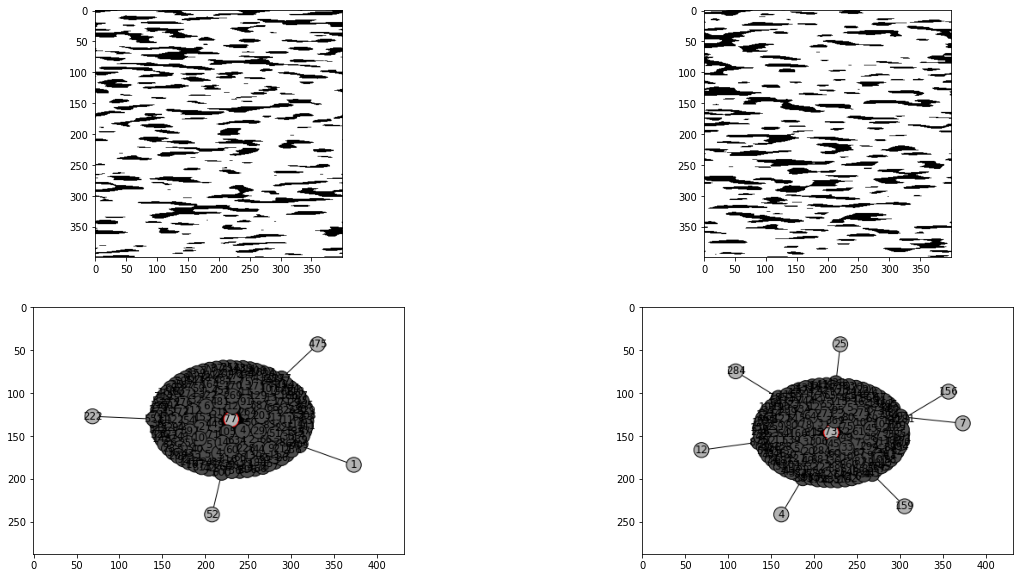

In [378]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(221)
plt.imshow(plt.imread('/home/namit/data/selected_extreme_aspect/cosine_works/4.png'))
fig.add_subplot(222)
plt.imshow(plt.imread('/home/namit/data/selected_extreme_aspect/cosine_works/7.png'))
fig.add_subplot(223)
plt.imshow(plt.imread('/home/namit/codes/CoMoDO/graphs/4.png'))
fig.add_subplot(224)
plt.imshow(plt.imread('/home/namit/codes/CoMoDO/graphs/7.png'))

In [381]:
euclidean_distance = []
cosine_distance = []

for i in range(1, len(v1)+1):
    part_v1, part_v2 = v1[:i], v2[:i]
    cosine_distance.append(  dist.cosine(part_v1, part_v2) / np.max(distances_cosine)  )
    euclidean_distance.append(  np.linalg.norm(part_v1 - part_v2) / np.max(distances_euclidean) )
    

In [382]:
print(euclidean_distance[-1], cosine_distance[-1])

0.043689999620735984 0.06988687955258495


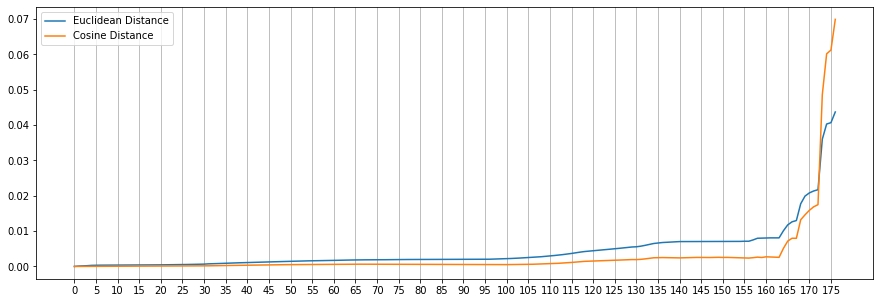

In [383]:
fig = plt.figure(figsize=(15,5))
plt.plot(euclidean_distance, label="Euclidean Distance")
plt.plot(cosine_distance, label='Cosine Distance')
a = plt.xticks(np.arange(0, len(cosine_distance)+1, 5.0))
plt.grid(axis = 'x')
plt.legend()

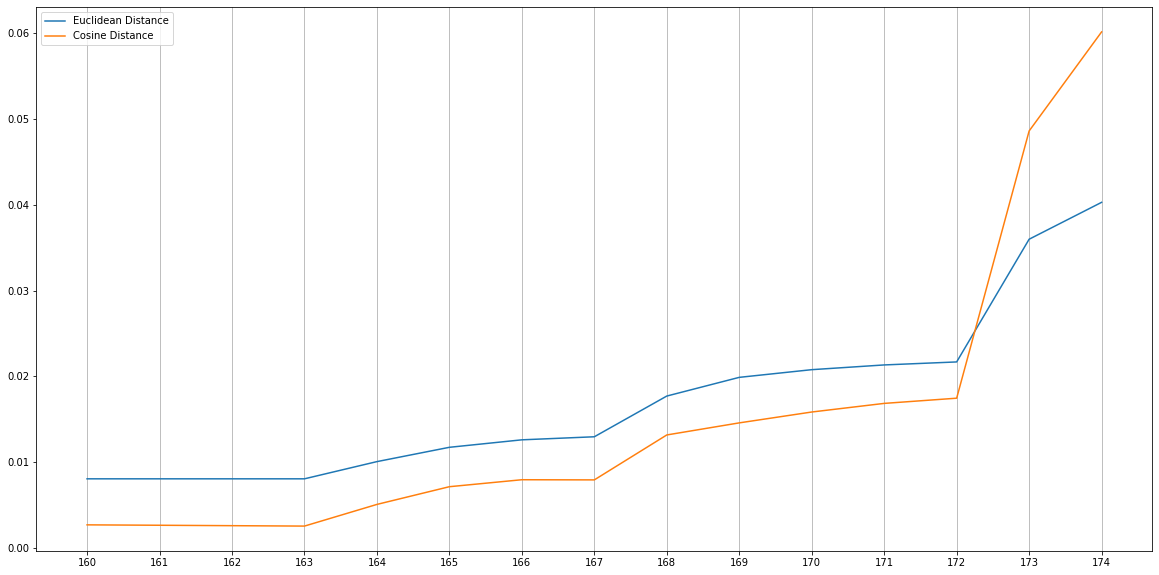

In [384]:
# zoom in
fig = plt.figure(figsize=(20,10))
plt.plot(np.arange(160, 175, 1.0), euclidean_distance[160:175], label="Euclidean Distance")
plt.plot(np.arange(160, 175, 1.0), cosine_distance[160:175], label='Cosine Distance')
a = plt.xticks(np.arange(160, 175, 1.0))
plt.grid(axis = 'x')
plt.legend()

#### components 169-173

<ipython-input-385-77d671b7bd20>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',f'10x80 morph #3', f'10x80 morph #5'])


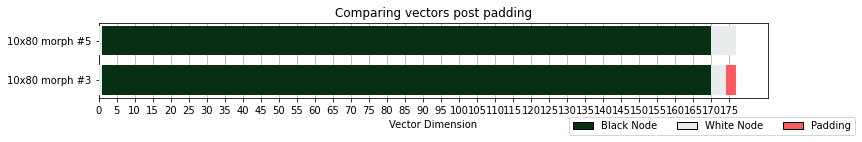

In [385]:
padded_vectors = [v1,v2]
fig, ax = plt.subplots(figsize=(12,2))
ticks = np.arange(0, len(padded_vectors[0]), 20)
minor_ticks = np.arange(0, len(padded_vectors[0]), 5)
ax.set_xticks(ticks)
ax.set_xticks(ticks, minor=True)
ax.set_yticklabels(['',f'10x80 morph #3', f'10x80 morph #5'])
plt.grid(True, axis='x', linestyle='-',zorder=0)

plt.setp(ax.get_xminorticklabels(), visible=False)

plt.xlabel("Vector Dimension")
plt.title("Comparing vectors post padding")

legend = [Patch(facecolor=[8/255,46/255,20/255],     edgecolor='k',label='Black Node'),
          Patch(facecolor=[232/255,236/255,236/255], edgecolor='k',label='White Node'),
          Patch(facecolor=[255/255,90/255,95/255],   edgecolor='k',label='Padding')]
plt.legend(handles=legend, bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=3)

plt.tight_layout()



for i in range(len(padded_vectors[0])):
    if padded_vectors[0][i]==0:
        c1 = [255/255,90/255,95/255]
    elif padded_vectors[0][i]>0:
        c1 = [232/255,236/255,236/255]
    else:
        c1 = [8/255,46/255,20/255]
        
    if padded_vectors[1][i]==0:
        c2 = [255/255,90/255,95/255]
    elif padded_vectors[1][i]>0:
        c2 = [232/255,236/255,236/255]
    else:
        c2 = [8/255,46/255,20/255]
        
    color=[c1,c2]
    plt.barh([0,1], [1,1], left=i, color=color, height=0.75, orientation='horizontal',zorder=3)
    a = plt.xticks(np.arange(0, len(cosine_distance)+1, 5.0))
plt.show()

<ipython-input-386-3b1589497c94>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['',f'10x80 morph #3', f'10x80 morph #5'])


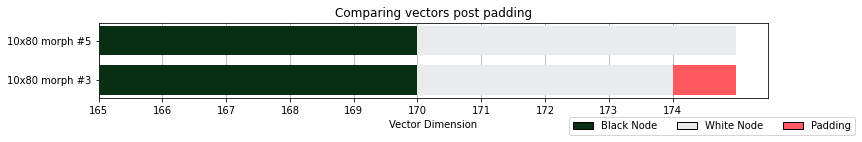

In [386]:
padded_vectors = [v1[165:175],v2[165:175]]
fig, ax = plt.subplots(figsize=(12,2))
ticks = np.arange(0, len(padded_vectors[0]), 20)
minor_ticks = np.arange(0, len(padded_vectors[0]), 5)
ax.set_xticks(ticks)
ax.set_xticks(ticks, minor=True)
ax.set_yticklabels(['',f'10x80 morph #3', f'10x80 morph #5'])
plt.grid(True, axis='x', linestyle='-',zorder=0)

plt.setp(ax.get_xminorticklabels(), visible=False)

plt.xlabel("Vector Dimension")
plt.title("Comparing vectors post padding")

legend = [Patch(facecolor=[8/255,46/255,20/255],     edgecolor='k',label='Black Node'),
          Patch(facecolor=[232/255,236/255,236/255], edgecolor='k',label='White Node'),
          Patch(facecolor=[255/255,90/255,95/255],   edgecolor='k',label='Padding')]
plt.legend(handles=legend, bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=3)

plt.tight_layout()



for i in range(len(padded_vectors[0])):
    if padded_vectors[0][i]==0:
        c1 = [255/255,90/255,95/255]
    elif padded_vectors[0][i]>0:
        c1 = [232/255,236/255,236/255]
    else:
        c1 = [8/255,46/255,20/255]
        
    if padded_vectors[1][i]==0:
        c2 = [255/255,90/255,95/255]
    elif padded_vectors[1][i]>0:
        c2 = [232/255,236/255,236/255]
    else:
        c2 = [8/255,46/255,20/255]
        
    color=[c1,c2]
    plt.barh([0,1], [1,1], left=i, color=color, height=0.75, orientation='horizontal',zorder=3)
    a = plt.xticks(np.arange(10))
    ax.set_xticklabels(np.arange(165, 175))
plt.show()

In [387]:
print([print(i) for i in v1[165:175]])
print([print(i) for i in v2[165:175]])

-0.5
-0.6
-0.6666666666666666
-0.6666666666666666
-0.75
0.08333333333333333
0.2727272727272727
0.35714285714285715
1.0
0.0
[None, None, None, None, None, None, None, None, None, None]
-0.6666666666666666
-0.7272727272727273
-0.75
-1.0
-1.0
0.25
0.13953488372093023
0.25
0.20689655172413793
0.5
[None, None, None, None, None, None, None, None, None, None]


In [388]:
image_set_directory = '/home/namit/data/selected_extreme_aspect/cosine_works'



# signature_function='surface_volume_ratio_sig'
signature_function='shape_ratio_sig'
# signature_function='fractal_dimension_sig'


visualize_graphs=False
weighted=False
cosine=True

components = compute_distance(image_set_directory, signature_function, visualize_graphs, weighted, cosine)

/home/namit/data/selected_extreme_aspect/cosine_works/4.png
Pruned 0 component(s)
/home/namit/data/selected_extreme_aspect/cosine_works/7.png
Pruned 0 component(s)


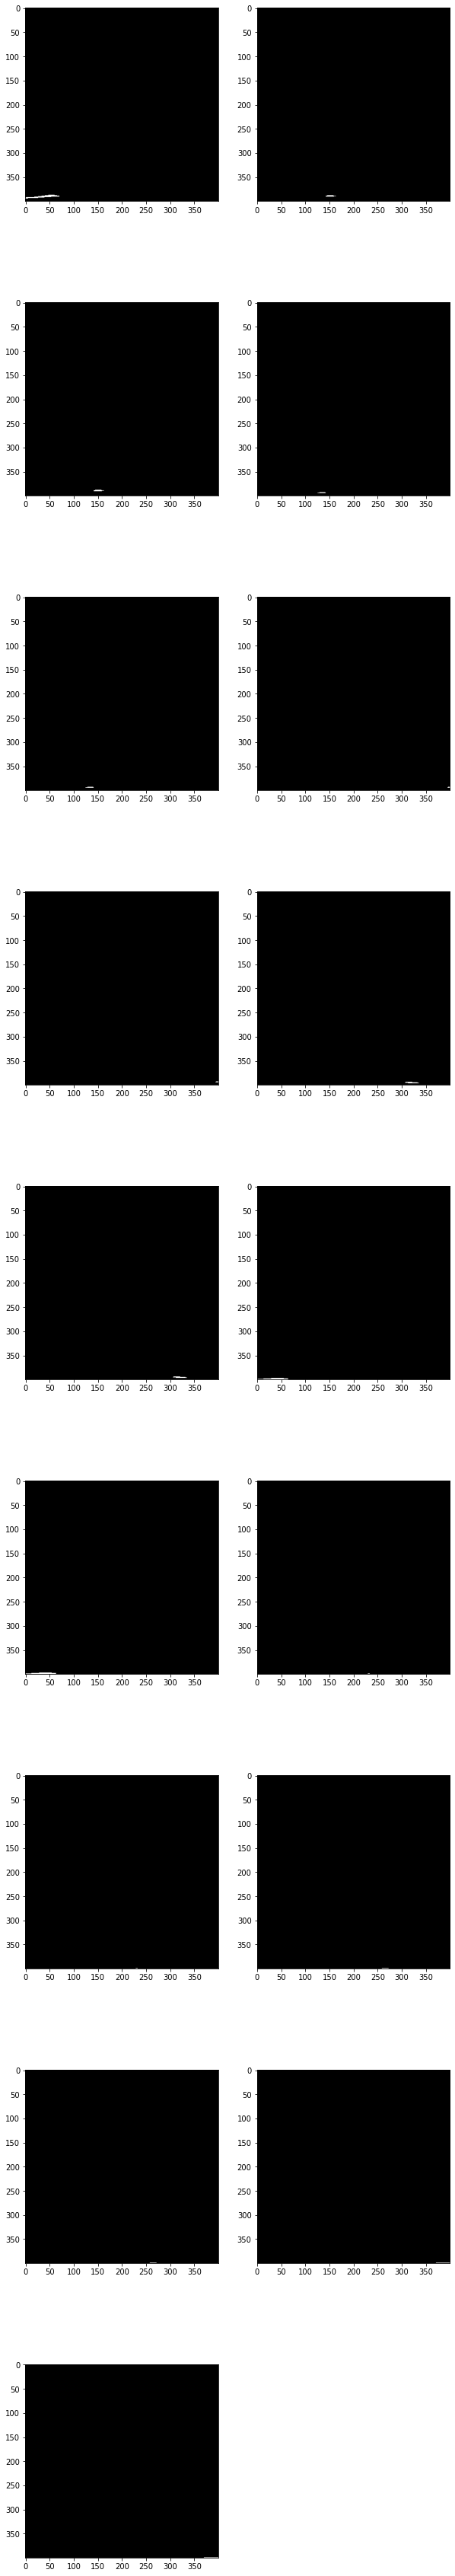

In [389]:
# plot each component individualy
image_num = 0
fig = plt.figure(figsize=(10,70))
for i in range(len(components[image_num][165:175])):
    ax = fig.add_subplot(10, 2, (i*2+1))
    ax.imshow(components[image_num][165:175][i], cmap='gray')
for i in range(1,len(components[image_num][165:175])):
    ax = fig.add_subplot(10, 2, i*2)
    ax.imshow(components[image_num][165:175][i], cmap='gray')

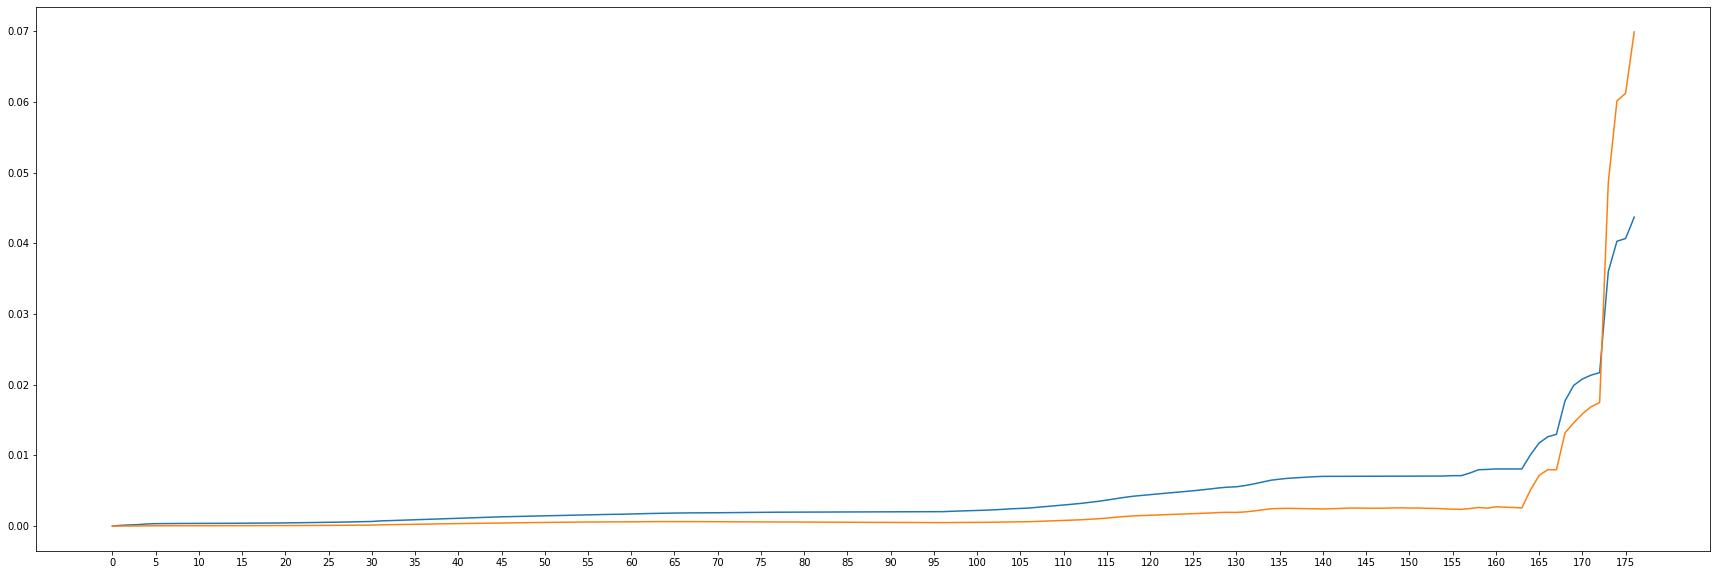

In [227]:
fig = plt.figure(figsize=(30,10))
plt.plot(euclidean_distance)
plt.plot(cosine_distance)
a = plt.xticks(np.arange(0, len(cosine_distance)+1, 5.0))


upgma clustering from distance matrix

In [7]:
plot_fancy_dendogram(distances)

TypeError: plot_fancy_dendogram() takes 1 positional argument but 2 were given

Total components in each morph:  [60, 51]


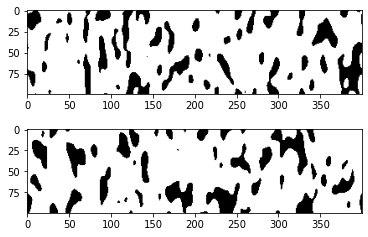

In [51]:
print("Total components in each morph: ", [len(i) for i in image_vectors])

imgs = [io.imread(p) for p in Path(image_set_directory).iterdir()]
fig = plt.figure()
ax = fig.add_subplot(211)
ax.imshow(imgs[0], cmap='gray')
ax = fig.add_subplot(212)
ax.imshow(imgs[1], cmap='gray')


visualizing indivisual components

In [40]:
rags[0].nodes[i+1]

{'labels': [62],
 'pixel count': 4,
 'mean color': array([0., 0., 0.]),
 'weight': 0.5}

In [13]:
image_num = 1
print(len(components[image_num]))
print(int(len(components[image_num])/2))

51
25


In [20]:
# plt.imshow(components[1][0])
regions = measure.regionprops(components[1][0].astype(np.int64))


In [23]:
regions[0]['BoundingBox']

(0, 0, 1, 2)

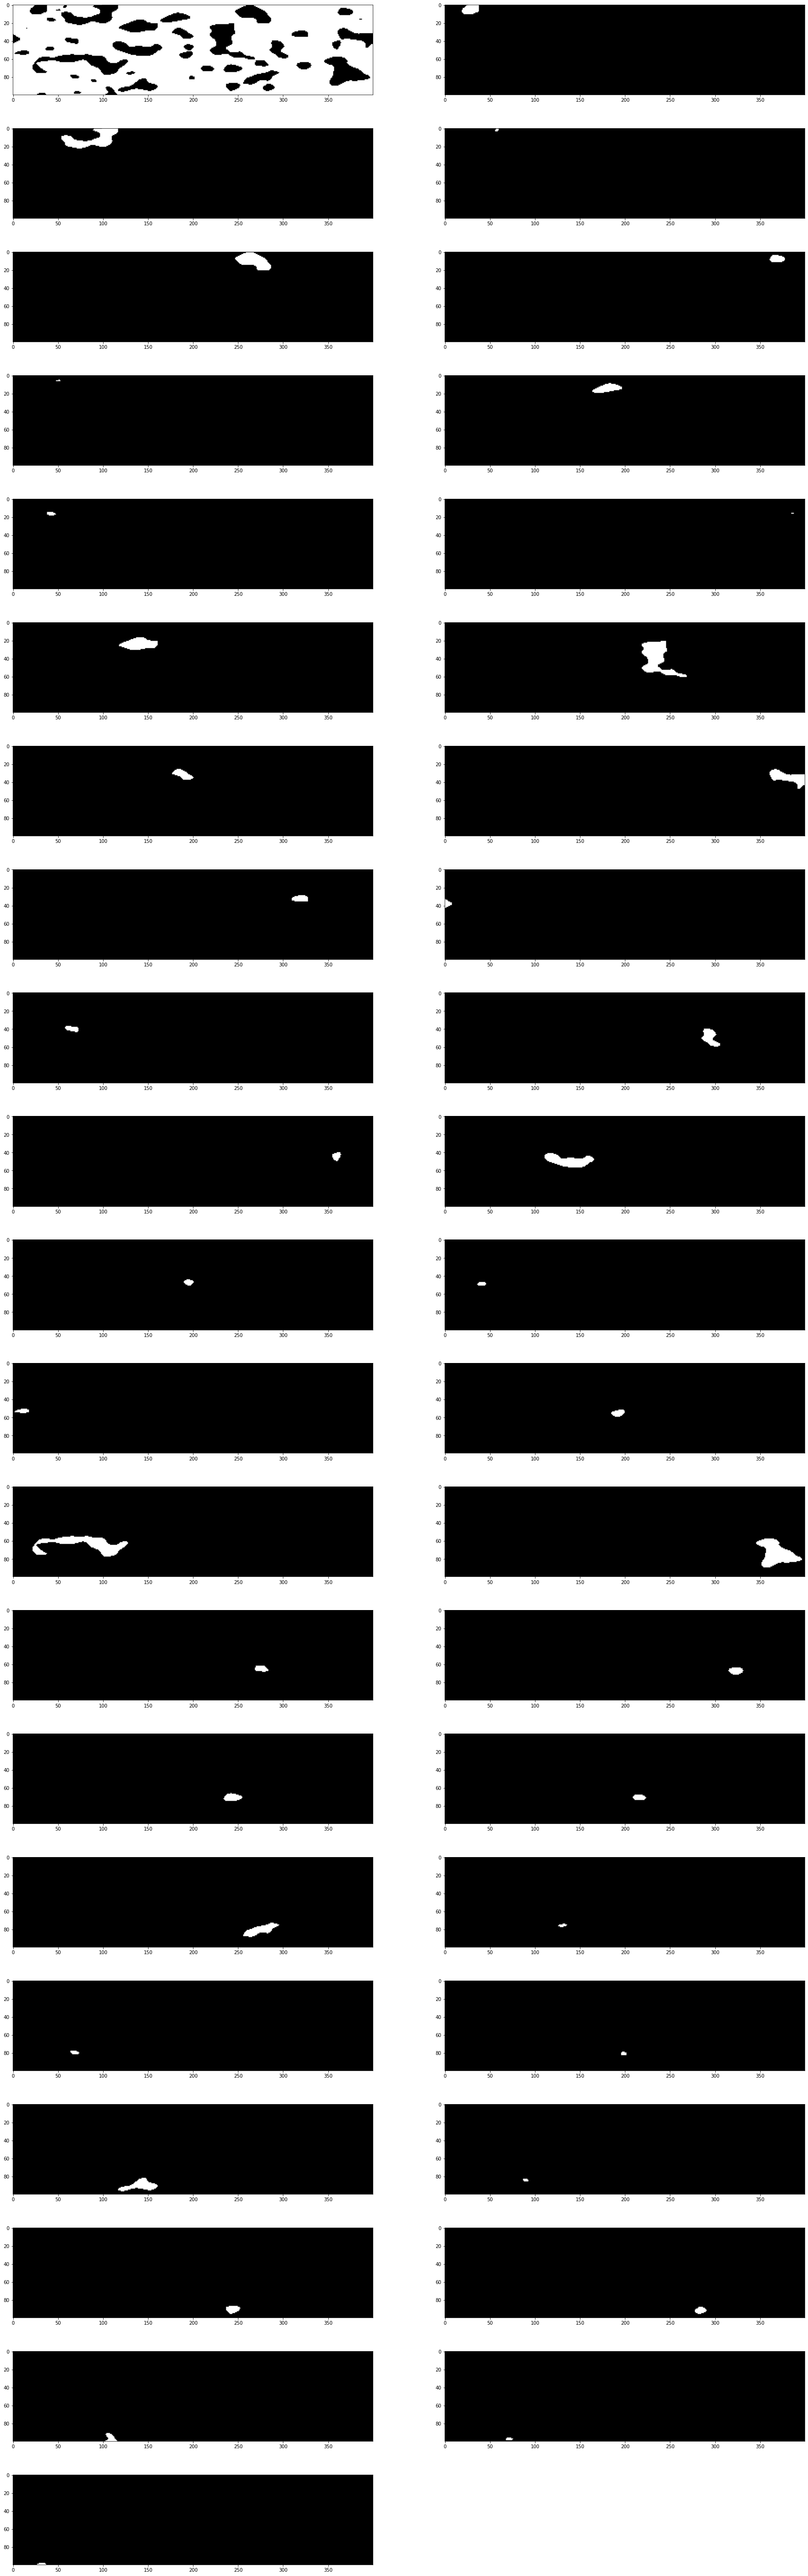

In [38]:
# plot each component individualy
image_num = 1
fig = plt.figure(figsize=(30,100))
for i in range(len(components[image_num])):
    ax = fig.add_subplot(int(len(components[image_num])/2)+1, 2, i+1)
    ax.imshow(components[image_num][i], cmap='gray')
#     ax.set_title(f"pixel count {rags[image_num].nodes[i+1]['pixel count']}, mean color {rags[image_num].nodes[i+1]['mean color']}")